<a href="https://colab.research.google.com/github/Wajih24/NLP_projects/blob/main/Roberta_base_Hope_Speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.7 MB/s 
     |████████████████████████████████| 880 kB 46.4 MB/s 
     |████████████████████████████████| 1.3 MB 71.3 MB/s 
     |████████████████████████████████| 3.0 MB 58.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0d3d536a5a4f67a0a32f3fc166c364a05a672b5cccf3ad504e0fcbfeeba8d7f2
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
train=pd.read_csv('https://raw.githubusercontent.com/Wajih24/NLP_projects/main/Datasets/english_hope_train.csv', header=None, names=['tweets','label','empty'], sep="\t")
train['labels'] =  LabelEncoder().fit_transform(train['label'])
train = train.drop(columns=['label','empty'])
train

,tweets,labels
0,these tiktoks radiate gay chaotic energy and i...,1
1,@Champions Again He got killed for using false...,1
2,It's not that all lives don't matter,1
3,Is it really that difficult to understand? Bla...,1
4,Whenever we say black isn't that racists? Why...,1
...,...,...
22757,It's a load of bollocks every life matters sim...,1
22758,no say it because all lives matter! deku would...,1
22759,God says her life matters,1
22760,This video is just shit. A bunch of whiny ass ...,1


In [4]:
val=pd.read_csv('https://raw.githubusercontent.com/Wajih24/NLP_projects/main/Datasets/english_hope_dev.csv', header=None, names=['tweets','label','empty'], sep="\t")
val['labels'] = LabelEncoder().fit_transform(val['label'])

val = val.drop(columns=['label','empty'])
val

,tweets,labels
0,Thats it.... like....I dont like that statue,1
1,@Generation X Counting money that she been giv...,1
2,@Paola Hernandez i never said to be intolerant...,1
3,@Firstlast300 Wow An opinion is that I don't l...,1
4,WOW!!!!!!!That was so so inspiring and incredi...,0
...,...,...
2838,Such fake sentiment. .,1
2839,@A G black lives arent undervalued compared to...,1
2840,People who pulled it down can and will be arre...,1
2841,@Aaron Castellanos It will be a two hour movie...,1


In [ ]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [ ]:
print('Training set size:',train.shape)
print('validation set size:',val.shape)

Training set size: (22762, 2)
validation set size: (2843, 2)


In [ ]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train.labels.values),
                                        y = train.labels.values                                              
                                    )
class_weights = dict(zip(np.unique(train.labels.values ), class_weights))

class_weights

{0: 3.867142371729528, 1: 0.36516186992652483, 2: 344.8787878787879}

In [ ]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweets.to_numpy(),
      label = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [ ]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('roberta-base')
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.auto.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _,pooled_output = self.auto(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

In [ ]:
model = RFClassifier(3)
model = model.to(device)

In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-uncased.bin')
    best_accuracy = val_acc

Epoch: 01 | Epoch Time: 8m 33s
Train Loss 0.2382546616927459 accuracy 0.9205693700026361
Val Loss 0.20913055982817425 accuracy 0.9124164614843475

Epoch: 02 | Epoch Time: 8m 32s
Train Loss 0.16532964568998498 accuracy 0.9412617520428785
Val Loss 0.18860184418016604 accuracy 0.9268378473443546

Epoch: 03 | Epoch Time: 8m 32s
Train Loss 0.1284369990939871 accuracy 0.9581319743432036
Val Loss 0.21235862598241714 accuracy 0.9215617305663032

Epoch: 04 | Epoch Time: 8m 32s
Train Loss 0.10292428715567868 accuracy 0.9698181179158246
Val Loss 0.2286920908085081 accuracy 0.9257826239887442

Epoch: 05 | Epoch Time: 8m 32s
Train Loss 0.08076264746742208 accuracy 0.9780335647131184
Val Loss 0.27617997320871174 accuracy 0.9243756595145972



In [5]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'].numpy(), label='train accuracy')
plt.plot(history['val_acc'].numpy(), label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

"plt.plot(history['train_acc'].numpy(), label='train accuracy')\nplt.plot(history['val_acc'].numpy(), label='validation accuracy')\nplt.title('Training history')\nplt.ylabel('Accuracy')\nplt.xlabel('Epoch')\nplt.legend()"

In [ ]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.9243756595145972

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [ ]:
val_data_loader

In [ ]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [ ]:
class_name = ['Hope_speech','Non_hope_speech','not-English']

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0, digits=4))

                 precision    recall  f1-score   support

    Hope_speech     0.6014    0.6434    0.6217       272
Non_hope_speech     0.9616    0.9548    0.9582      2569
    not-English     0.0000    0.0000    0.0000         2

       accuracy                         0.9244      2843
      macro avg     0.5210    0.5327    0.5266      2843
   weighted avg     0.9264    0.9244    0.9253      2843



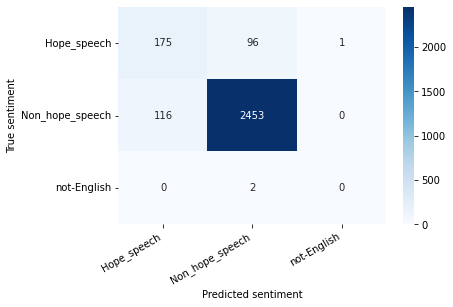

In [ ]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

In [ ]:
df = pd.read_excel("/content/Labeled Tweets By Sentiment & HateSpeech.xlsx")
df.rename(columns = {'Class':'Hate_Class'}, inplace = True)
df

,State,Role,Name,Tweets,num_date,Party,Status,Retweet,Tweets_cleaned,Sentiments,Negative,Positive,Neutral,Hate_Class,hate,offensive,neither
0,Minnesota,Senator,Amy Klobuchar,Seriously? Maybe the President should focus o...,2020-03-14,Democrat,4,No,seriously maybe president focus getting testin...,neutral,18.2,0.0,81.8,neither,6.56,34.02,59.42
1,Minnesota,Senator,Amy Klobuchar,There are so many heroes on the front lines as...,2020-03-14,Democrat,4,No,many heroes front lines face pandemic nurses d...,neutral,0.0,34.4,65.6,neither,4.64,33.39,61.96
2,Minnesota,Senator,Amy Klobuchar,RT @Yamiche : This is why @JudyWoodruff is ama...,2020-03-14,Democrat,4,Yes,amazing reminded viewers tonight think others ...,neutral,0.0,18.3,81.7,neither,4.81,30.89,64.30
3,Minnesota,Senator,Amy Klobuchar,With the House passing the #FamiliesFirstBill ...,2020-03-14,Democrat,4,No,house passing familiesfirstbill last night sen...,neutral,13.9,28.7,57.4,neither,5.50,32.16,62.34
4,Minnesota,Senator,Amy Klobuchar,Seniors are more at risk to the coronavirus pa...,2020-03-14,Democrat,4,No,seniors risk coronavirus pandemic cities like ...,positive,9.0,52.4,38.6,neither,4.46,33.03,62.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61461,Texas,Senator,Ted Cruz,Exactly the right move. Last year @SenBillCass...,2020-05-31,Republican,1,No,exactly right move last year amp called design...,negative,54.3,0.0,45.7,neither,5.11,36.03,58.87
61462,South Carolina,Senator,Tim Scott,RT @postandcourier : It’s 11:00. A county-wide...,2020-05-31,Republican,1,Yes,it’s county wide curfew effect charleston,neutral,0.0,0.0,100.0,neither,3.85,33.07,63.08
61463,South Carolina,Senator,Tim Scott,RT @FoxNewsSunday : EXCLUSIVE: Chris will be j...,2020-05-31,Republican,1,Yes,exclusive chris joined senator tim scott discu...,neutral,26.0,6.7,67.3,neither,4.15,32.97,62.88
61464,South Carolina,Senator,Tim Scott,For those who believe that violence is a way t...,2020-05-31,Republican,1,No,believe violence way react selfishness tolerat...,neutral,26.8,33.5,39.6,neither,3.95,33.07,62.98


In [ ]:
# Create a set that contains only the text tweets
to_pred = df[['Tweets_cleaned']]
to_pred["tweets"] = to_pred['Tweets_cleaned']
to_pred['labels'] = [0 for i in range(len(to_pred))] #generate a fake label
to_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Tweets_cleaned,tweets,labels
0,seriously maybe president focus getting testin...,seriously maybe president focus getting testin...,0
1,many heroes front lines face pandemic nurses d...,many heroes front lines face pandemic nurses d...,0
2,amazing reminded viewers tonight think others ...,amazing reminded viewers tonight think others ...,0
3,house passing familiesfirstbill last night sen...,house passing familiesfirstbill last night sen...,0
4,seniors risk coronavirus pandemic cities like ...,seniors risk coronavirus pandemic cities like ...,0
...,...,...,...
61461,exactly right move last year amp called design...,exactly right move last year amp called design...,0
61462,it’s county wide curfew effect charleston,it’s county wide curfew effect charleston,0
61463,exclusive chris joined senator tim scott discu...,exclusive chris joined senator tim scott discu...,0
61464,believe violence way react selfishness tolerat...,believe violence way react selfishness tolerat...,0


In [ ]:
# Create the data loader for the model to predict
to_pred_data_loader = create_data_loader(to_pred,tokenizer,MAX_LEN,BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# perform the predictions
y_review_texts1, y_pred1, y_pred_probs1, y_test1 = get_predictions(
  model,
  to_pred_data_loader
)

y_pred1 , y_pred_probs1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Convert the probs into percentage
sm = torch.nn.Softmax()
probabilities = sm(y_pred_probs1) 
probabilities = probabilities.numpy()
probabilities

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[1.5357712e-03, 9.9816626e-01, 2.9793486e-04],
       [8.4868987e-04, 9.9876308e-01, 3.8822426e-04],
       [2.9347886e-03, 9.9675155e-01, 3.1368676e-04],
       ...,
       [9.4464241e-04, 9.9875236e-01, 3.0297477e-04],
       [8.7178382e-04, 9.9876815e-01, 3.6010161e-04],
       [2.8016341e-03, 9.9646735e-01, 7.3103857e-04]], dtype=float32)

In [ ]:
# Convert the prediction into the actual class names
class_name = ['Hope_speech','Non_hope_speech','not-English']
y_pred1 = [class_name[i] for i in y_pred1]
y_pred1

['Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',
 'Non_hope_speech',


In [ ]:
# Add the new columns to the dataset
df['Hope_Class'] = y_pred1
df['Hope_speech'] = probabilities[:,0].tolist()
df['Non_hope_speech'] = probabilities[:,1].tolist()
df['not-English'] = probabilities[:,2].tolist()

df['Hope_speech'] = df['Hope_speech'].apply(lambda x : round(x*100,2))
df['Non_hope_speech'] = df['Non_hope_speech'].apply(lambda x : round(x*100,2))
df['not-English'] = df['not-English'].apply(lambda x : round(x*100,2))

df[['Hope_Class','Hope_speech','Non_hope_speech','not-English']]

,Hope_Class,Hope_speech,Non_hope_speech,not-English
0,Non_hope_speech,0.15,99.82,0.03
1,Non_hope_speech,0.08,99.88,0.04
2,Non_hope_speech,0.29,99.68,0.03
3,Non_hope_speech,0.09,99.87,0.04
4,Non_hope_speech,0.46,99.50,0.04
...,...,...,...,...
61461,Non_hope_speech,0.09,99.89,0.03
61462,Non_hope_speech,0.11,99.85,0.05
61463,Non_hope_speech,0.09,99.88,0.03
61464,Non_hope_speech,0.09,99.88,0.04


In [ ]:
df.to_excel(r'Labeled Tweets By Sentiment & HateSpeech & HopeSpeech.xlsx', index = False, header=True)